# Supervised Learning with Feedforward Neural Networks

Supervised machine learning is the type you probably already know about. The basic idea is that you have a set of inputs and a set of outputs, and you want to learn the relationship between them. For example, you might have a set of images of handwritten digits and you want to learn to recognize which digit is in each image. Or you might have a set of emails and you want to learn to recognize which ones are spam. Or you might have a set of audio clips and you want to learn to recognize what words were spoken in each clip.

*TLDR:* in supervised machine learning, we train an algorithm or neural network to predict outputs, given inputs.

The two basic types of supervised learning are:
- *Classfication:* outputs are discrete categories. For example, types of particles in the Standard Model, or handwritten digits.
- *Regression:* outputs are continuous or allow for interpolation, such as the mass of a particle or the price of a house.

## Classification: Some Simple Math Problems

We'll exemplify the idea in a simple problem: determining whether the product of two numbers $q_1$ and $q_2$ is positive.

We'll start by generating the data that models this problem.

In [1]:
!pip install torch torchsummary

In [2]:
from __future__ import print_function  # for backwards compatibility: uses print() also in python2

import torch

import matplotlib.pyplot as plt  # for plotting
from mpl_toolkits.mplot3d import Axes3D  # for plotting

def f(q1, q2):
    return int(q1 * q2 > 0)

print(f(1, 1),f(-1,1),f(0,1))

# Generate the training set
x, y = [], []
for q1 in range(-5, 6):
    for q2 in range(-5,6):
        x.append([q1, q2])
        y.append([f(q1, q2)])

x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

1 0 0


Now we will set up the neural network. This takes in 2 numbers and will output one. 

You'll notice alternative sequences of linear layers and tanh non-linearities, similar to earlier in the course, but now we end with sigmoid:
$$\sigma(x) = \frac{1}{1+e^{-x}}$$
which is a non-linear function that maps any real number to a number between 0 and 1. This is useful for classification problems, since we can interpret the output as a probability.

In [3]:
# Set up and initialize the NN
my_nn = torch.nn.Sequential(
    torch.nn.Linear(2, 10),
    torch.nn.Tanh(),
    torch.nn.Linear(10, 10),
    torch.nn.Tanh(),
    torch.nn.Linear(10, 1),
    torch.nn.Sigmoid()
)

import torchsummary
torchsummary.summary(my_nn, (2, ), batch_size=0, device='cpu')



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [0, 10]              30
              Tanh-2                    [0, 10]               0
            Linear-3                    [0, 10]             110
              Tanh-4                    [0, 10]               0
            Linear-5                     [0, 1]              11
           Sigmoid-6                     [0, 1]               0
Total params: 151
Trainable params: 151
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Now set up some hyperparameters related to learning, the optimizer, and the loss function.

### **Loss function**
 we choose is typical for a binary classification problem such as this one. It is called the *binary cross entropy* and is defined as
$$L = -\frac{1}{N}\sum_{i=1}^N y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)$$
where $y_i$ is the true label (0 or 1) and $\hat{y}_i$ is the predicted label (between 0 and 1).

The basic idea of this loss is that if the true label is 1, then we want to maximize $\hat{y}_i$, and if the true label is 0, then we want to maximize $1-\hat{y}_i$. This is a good loss function for classification problems because it penalizes the network more for being very wrong than for being a little bit wrong. The value inside the log is effectively never exactly 0 or 1, so we don't have to worry about multiplying by infinity.

### **Optimizer**
We choose to use stochastic gradient descent, which differs from gradient descent due to mini-batches. The idea is that instead of computing the gradient of the loss function over the entire dataset, we compute it over a small subset of the dataset called a mini-batch. This is much faster, and the gradient is still a good approximation to the true gradient. The word "stochastic" refers to the fact that the mini-batches are often chosen randomly (though there are other ways for stochasticity to enter).

In [4]:
# Define the NN hyperparameters
learning_rate = 0.01
epochs = 100

# Specify the optimizer
sgd = torch.optim.SGD(my_nn.parameters(), lr=learning_rate)  # use SGD optimizer
criterion = torch.nn.BCELoss()

Time for the train loop.

In [5]:
# Train the NN
avg_losses = []
for epoch in range(epochs):
    avg_loss = 0
    for i in range(len(x)):
        sgd.zero_grad()
        y_hat = my_nn(x[i])
        loss = criterion(y_hat, y[i])
        loss.backward()
        avg_loss += loss.data
        sgd.step()

    avg_losses.append(avg_loss)

print("\nTraining complete!")



Training complete!


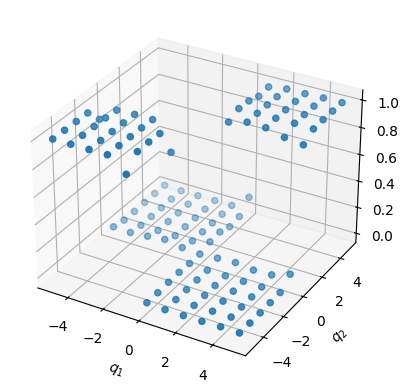

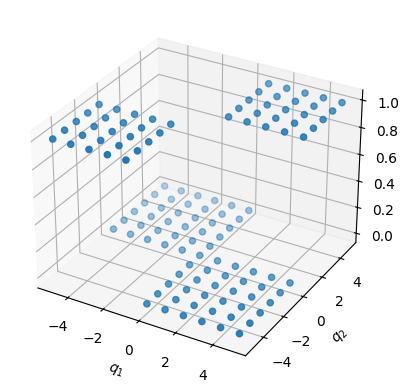

In [6]:

# Plot the loss during training
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(avg_losses, 'o')  # show average losses
plt.title("Average losses per epoch")
plt.xlabel("Epochs")
plt.ylabel("Avg accuracy")
plt.yscale('log')
plt.savefig("./example_1.1_loss.pdf", dpi=300, bbox_inches='tight')
plt.close()


# Plot prediction of NN
y_hat = my_nn(x)
x, y_hat = x.detach().numpy(), y_hat.detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([q[0] for q in x], [q[1] for q in x], [f for f in y_hat.flatten()])
ax.set_xlabel('$q_1$')
ax.set_ylabel('$q_2$')
ax.set_zlabel('y')
# plt.savefig("./example_1.1_prediction.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


# Visualize with decision boundary 0.5
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([q[0] for q in x], [q[1] for q in x], [f.round() for f in y_hat.flatten()])
ax.set_xlabel('$q_1$')
ax.set_ylabel('$q_2$')
ax.set_zlabel('y')
# plt.savefig("./example_1.1_prediction_rounded.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### Three Classes

In this example we have three classes instead of two. Instead of sigmoid in the last layer, we will use softmax, which is a generalization of sigmoid to multiple classes. It is defined as
$$\sigma_i(x) = \frac{e^{x_i}}{\sum_{j=1}^N e^{x_j}}$$
where $x_i$ is the $i^\text{th}$ element of the input vector $x$ and $N$ is the number of classes. The output of the softmax is a vector of length $N$ whose elements sum to 1. We can interpret each element as the probability that the input belongs to the corresponding class.

Instead of binary cross-entropy loss, we'll use a natural generalization called *categorical cross-entropy* loss, which is defined as

$$L = -\frac{1}{N}\sum_{i=1}^N y_{i,j} \sum_j \log(\hat{y}_{i,j})$$

where $y_{i,j}$ is the true label (0 or 1) for the $i^{th}$ input and $j^{th}$ class, and $\hat{y}_{i,j}$ is the predicted label (between 0 and 1) for the $i^{th}$ input and $j^{th}$ class.

Why does this reproduce the binary cross entropy in the $j=2$ case? (Remember: y's are interpreted as probabilities).


Training complete!


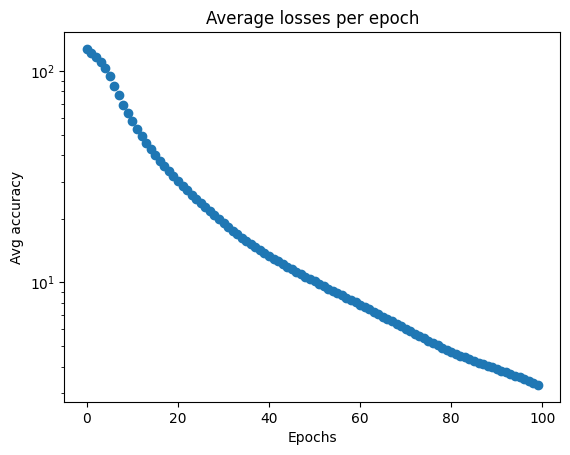

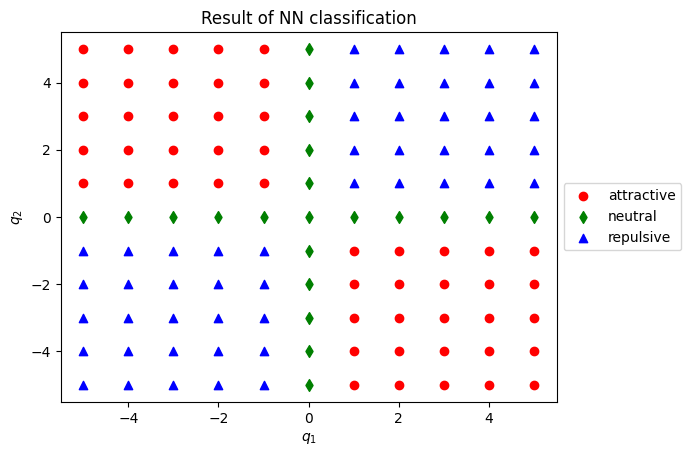

In [7]:



# (e) Implement with three sets
# new labeling function. Assigns class '0' to 'attractive', '1' to 'neutral', '2' to 'repulsive'
def f(q1, q2):
    if q1*q2 < 0:
        return 0
    elif q1*q2 == 0:
        return 1
    else:
        return 2

# new NN, now with three output nodes and softmax activation
my_nn = torch.nn.Sequential(
    torch.nn.Linear(2, 10),
    torch.nn.Tanh(),
    torch.nn.Linear(10, 10),
    torch.nn.Tanh(),
    torch.nn.Linear(10, 3)
    # note that torch applies softmax automatically when using torch.nn.CrossEntropyLoss
)
# Optional
# import torchsummary
# torchsummary.summary(my_nn, (2, ), batch_size=0, device='cpu')

# same optimizer, but with categorical_crossentropy rather than binary_crossentropy loss now
sgd = torch.optim.SGD(my_nn.parameters(), lr=learning_rate)  # use SGD optimizer
criterion = torch.nn.CrossEntropyLoss()

# same training set (with new function)
x, y = [], []
for q1 in range(-5, 6):
    for q2 in range(-5,6):
        x.append([q1, q2])
        y.append([f(q1, q2)])

x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# same training call
avg_losses = []
for epoch in range(epochs):
    avg_loss = 0
    for i in range(len(x)):
        sgd.zero_grad()
        y_hat = my_nn(x[i])
        loss = criterion(y_hat.unsqueeze(0), y[i])
        loss.backward()
        avg_loss += loss.data
        sgd.step()
    avg_losses.append(avg_loss)
print("\nTraining complete!")

# plot the loss
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(avg_losses, 'o')  # show average losses
plt.title("Average losses per epoch")
plt.xlabel("Epochs")
plt.ylabel("Avg accuracy")
plt.yscale('log')
plt.show()
# plt.savefig("./example_1.1e_loss.pdf", dpi=300, bbox_inches='tight')
plt.close()

# plot the predictions
y_hat = my_nn(x).detach().numpy()
y_hat = y_hat.argmax(1)
x = x.detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter([x[i][0] for i in range(len(x)) if y_hat[i] == 0], [x[i][1] for i in range(len(x)) if y_hat[i] == 0], c='r', marker='o', label='attractive')
ax.scatter([x[i][0] for i in range(len(x)) if y_hat[i] == 1], [x[i][1] for i in range(len(x)) if y_hat[i] == 1], c='g', marker='d', label='neutral')
ax.scatter([x[i][0] for i in range(len(x)) if y_hat[i] == 2], [x[i][1] for i in range(len(x)) if y_hat[i] == 2], c='b', marker='^', label='repulsive')
ax.set_xlabel('$q_1$')
ax.set_ylabel('$q_2$')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Result of NN classification")
plt.show()
#plt.savefig("./example_1.1e_prediction.pdf", dpi=300, bbox_inches='tight')
plt.close()

## Regression: $Z \to e^+ e^-$ decays

In this problem we'll use CERN OpenData taken from the website [opendata.cern.ch](http://opendata.cern.ch/record/545) to train a classifier to distinguish between $Z \to e^+ e^-$ decays and background events. The data is stored in the file `Zee.csv` and contains the following variables:
- `E1`, `E2`: The energy of the two electrons in GeV
- `pt1`, `pt2`: The transverse momentum of the two electrons in GeV
- `eta1`, `eta2`: The pseudorapidity of the two electrons
- `phi1`, `phi2`: The azimuthal angle of the two electrons
and some other data that won't be as relevant for us.

We will train a neural network to predict the invariant mass of the Z-boson from the transverse momenta `pt`, the pseudo-rapidities `eta` and the azimuthal angles `phi` of the electron and positron. The pseudo-rapidity is given by
$$\eta = -\ln(\tan(\theta/2))$$
where $\theta$ is the angle between the particle's momentum and the beam axis.
Of course, the exact formula for the invariant mass is known, but this is useful pedagogically because it will give us some confidence in the neural network.

In terms of these variables, the formula for the reconstructed invariant mass of the $Z$-boson is 
$M_Z^2 = 2 p_{T,1} p_{T,2} ( \cosh(\eta_1 - \eta_2) - \cos(\phi_1 - \phi_2))$.


We begin with some imports and implementing a function for the invariant mass.

In [8]:
from __future__ import print_function  # for backwards compatibility: uses print() also in python2

import torch
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt  # for plotting

# Optional: Seed the random number generator for reproducibility
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed)

def get_invariant_mass(pt1, pt2, eta1, eta2, phi1, phi2):
    return np.sqrt(2*pt1*pt2*(np.cosh(eta1-eta2)-np.cos(phi1-phi2)))


### Attempt 1: No normalization on the inputs

<>:66: SyntaxWarning: invalid escape sequence '\h'
<>:75: SyntaxWarning: invalid escape sequence '\h'
<>:66: SyntaxWarning: invalid escape sequence '\h'
<>:75: SyntaxWarning: invalid escape sequence '\h'
/var/folders/13/4h_rwpc12q15_80s7fq2msnw0000gp/T/ipykernel_55031/2943984400.py:66: SyntaxWarning: invalid escape sequence '\h'
  ax.set_ylabel('$\hat{y}$')
/var/folders/13/4h_rwpc12q15_80s7fq2msnw0000gp/T/ipykernel_55031/2943984400.py:75: SyntaxWarning: invalid escape sequence '\h'
  ax.set_ylabel('$\hat{y}/y$')


Epoch   0: MSE Loss 3836636.500000
Epoch   1: MSE Loss 1493800.875000
Epoch   2: MSE Loss 1493783.250000
Epoch   3: MSE Loss 1493771.625000
Epoch   4: MSE Loss 1493763.375000
Epoch   5: MSE Loss 1493751.750000
Epoch   6: MSE Loss 1493740.250000
Epoch   7: MSE Loss 1493729.375000
Epoch   8: MSE Loss 1493720.000000
Epoch   9: MSE Loss 1493711.000000
Epoch  10: MSE Loss 1493703.500000
Epoch  11: MSE Loss 1493695.000000
Epoch  12: MSE Loss 1493686.500000
Epoch  13: MSE Loss 1493677.750000
Epoch  14: MSE Loss 1493669.625000
Epoch  15: MSE Loss 1493660.750000
Epoch  16: MSE Loss 1493648.750000
Epoch  17: MSE Loss 1493641.125000
Epoch  18: MSE Loss 1493630.500000
Epoch  19: MSE Loss 1493619.750000

Training complete!


/var/folders/13/4h_rwpc12q15_80s7fq2msnw0000gp/T/ipykernel_55031/2943984400.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(range(len(y_hat)), [float(y_hat[i]) for i in range(len(y_hat))])


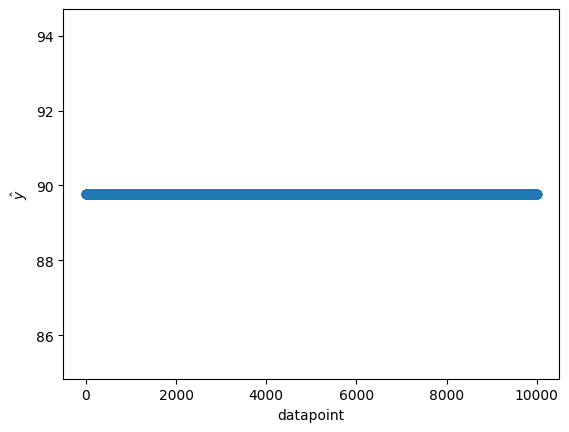

/var/folders/13/4h_rwpc12q15_80s7fq2msnw0000gp/T/ipykernel_55031/2943984400.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(range(len(y_hat)), [float(y_hat[i])/float(y[i]) for i in range(len(y_hat))])


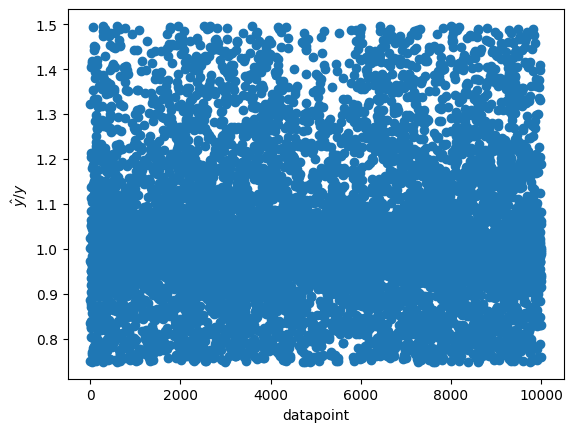

In [9]:
# create the NN
my_nn = torch.nn.Sequential(
    torch.nn.Linear(6, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
    torch.nn.Identity()
)

# define hyperparameters
learning_rate = 0.0001
epochs = 20

# set up the optimizer
sgd = torch.optim.SGD(my_nn.parameters(), lr=learning_rate)  # use SGD optimizer
criterion = torch.nn.MSELoss()

# generate the training set
x, y = [], []
zee_data = pd.read_csv('./Zee.csv')
inv_mass = get_invariant_mass(zee_data.pt1, zee_data.pt2, zee_data.eta1, zee_data.eta2, zee_data.phi1, zee_data.phi2)
for index, row in zee_data.iterrows():
   x.append([row['pt1'], row['pt2'], row['eta1'], row['eta2'], row['phi1'], row['phi2']])

x = np.asarray(x)
y = np.asarray([[y] for y in inv_mass])
x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# train the NN
avg_losses = []
for epoch in range(epochs):
    avg_loss = 0
    for i in range(len(x)):
        sgd.zero_grad()
        y_hat = my_nn(x[i])
        loss = criterion(y_hat, y[i])
        loss.backward()
        avg_loss += loss.data
        sgd.step()

    avg_losses.append(avg_loss)
    print("Epoch {:3d}: MSE Loss {:5f}".format(epoch, avg_loss))

print("\nTraining complete!")

# plot the loss during training
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(avg_losses, 'o')  # show average losses
plt.title("Average losses per epoch")
plt.xlabel("Epochs")
plt.ylabel("Avg accuracy")
plt.yscale('log')
plt.savefig("./example_1.2c_loss.pdf", dpi=300, bbox_inches='tight')
plt.close()

# plot prediction of NN
y_hat = my_nn(x)
x, y_hat = x.detach().numpy(), y_hat.detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(len(y_hat)), [float(y_hat[i]) for i in range(len(y_hat))])
ax.set_xlabel('datapoint')
ax.set_ylabel('$\hat{y}$')
# plt.savefig("./example_1.2c_prediction.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(len(y_hat)), [float(y_hat[i])/float(y[i]) for i in range(len(y_hat))])
ax.set_xlabel('datapoint')
ax.set_ylabel('$\hat{y}/y$')
# plt.savefig("./example_1.2c_rel_error.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### Attempt 2: Normalize the data a bit

<>:66: SyntaxWarning: invalid escape sequence '\h'
<>:75: SyntaxWarning: invalid escape sequence '\h'
<>:66: SyntaxWarning: invalid escape sequence '\h'
<>:75: SyntaxWarning: invalid escape sequence '\h'
/var/folders/13/4h_rwpc12q15_80s7fq2msnw0000gp/T/ipykernel_55031/4053048097.py:66: SyntaxWarning: invalid escape sequence '\h'
  ax.set_ylabel('$\hat{y}$ [GeV]')
/var/folders/13/4h_rwpc12q15_80s7fq2msnw0000gp/T/ipykernel_55031/4053048097.py:75: SyntaxWarning: invalid escape sequence '\h'
  ax.set_ylabel('$\hat{y}/y$')


Epoch   0: MSE Loss 118.058159
Epoch   1: MSE Loss 63.491653
Epoch   2: MSE Loss 47.220730
Epoch   3: MSE Loss 36.335369
Epoch   4: MSE Loss 29.221201
Epoch   5: MSE Loss 24.868595
Epoch   6: MSE Loss 22.254030
Epoch   7: MSE Loss 20.442148
Epoch   8: MSE Loss 18.913017
Epoch   9: MSE Loss 17.464666
Epoch  10: MSE Loss 16.031757
Epoch  11: MSE Loss 14.729654
Epoch  12: MSE Loss 13.492531
Epoch  13: MSE Loss 12.281277
Epoch  14: MSE Loss 11.215675
Epoch  15: MSE Loss 10.286216
Epoch  16: MSE Loss 9.502867
Epoch  17: MSE Loss 8.771898
Epoch  18: MSE Loss 8.131664
Epoch  19: MSE Loss 7.607183

Training complete!


/var/folders/13/4h_rwpc12q15_80s7fq2msnw0000gp/T/ipykernel_55031/4053048097.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(range(len(y_hat)), [100 * float(y_hat[i]) for i in range(len(y_hat))])


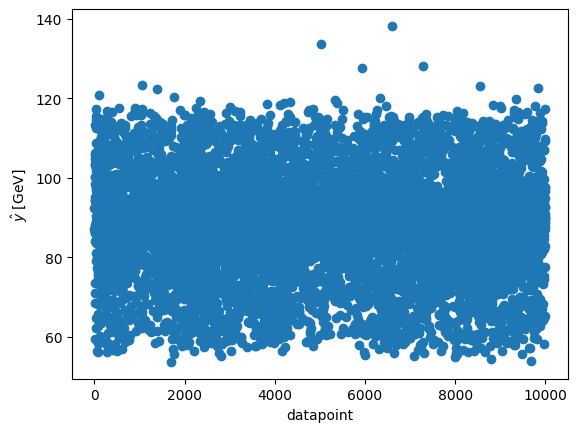

/var/folders/13/4h_rwpc12q15_80s7fq2msnw0000gp/T/ipykernel_55031/4053048097.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(range(len(y_hat)), [float(y_hat[i])/float(y[i]) for i in range(len(y_hat))])


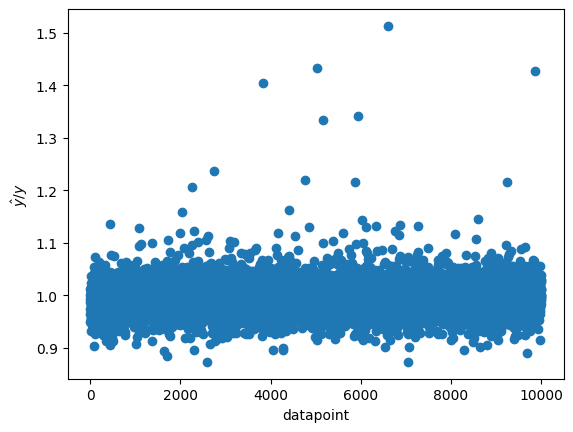

In [10]:
# Generate the data
x, y = [], []
zee_data = pd.read_csv('./Zee.csv')
inv_mass = get_invariant_mass(zee_data.pt1, zee_data.pt2, zee_data.eta1, zee_data.eta2, zee_data.phi1, zee_data.phi2)
for index, row in zee_data.iterrows():
   x.append([row['pt1']/100., row['pt2']/100., row['eta1'], row['eta2'], row['phi1'], row['phi2']])

x = np.asarray(x)
y = np.asarray([[y] for y in inv_mass])/100.
x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# Set up and initialize the NN
my_nn = torch.nn.Sequential(
    torch.nn.Linear(6, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
    torch.nn.Identity()
)

learning_rate = 0.01
epochs = 20
sgd = torch.optim.SGD(my_nn.parameters(), lr=learning_rate)  # use SGD optimizer
criterion = torch.nn.MSELoss()

# Train the NN
avg_losses = []
for epoch in range(epochs):
    avg_loss = 0
    for i in range(len(x)):
        sgd.zero_grad()
        y_hat = my_nn(x[i])
        loss = criterion(y_hat, y[i])
        loss.backward()
        avg_loss += loss.data
        sgd.step()

    avg_losses.append(avg_loss)
    print("Epoch {:3d}: MSE Loss {:5f}".format(epoch, avg_loss))

print("\nTraining complete!")


# Plot the loss during training
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(avg_losses, 'o')  # show average losses
plt.title("Average losses per epoch")
plt.xlabel("Epochs")
plt.ylabel("Avg accuracy")
plt.yscale('log')
plt.savefig("./example_1.2d_loss.pdf", dpi=300, bbox_inches='tight')
plt.close()


# Plot prediction of NN
y_hat = my_nn(x)
x, y_hat = x.detach().numpy(), y_hat.detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(len(y_hat)), [100 * float(y_hat[i]) for i in range(len(y_hat))])
ax.set_xlabel('datapoint')
ax.set_ylabel('$\hat{y}$ [GeV]')
# plt.savefig("./example_1.2d_prediction.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(len(y_hat)), [float(y_hat[i])/float(y[i]) for i in range(len(y_hat))])
ax.set_xlabel('datapoint')
ax.set_ylabel('$\hat{y}/y$')
# plt.savefig("./example_1.2d_rel_error.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


### Attempt 3: Use the Physically Sensible Variables

<>:55: SyntaxWarning: invalid escape sequence '\h'
<>:64: SyntaxWarning: invalid escape sequence '\h'
<>:55: SyntaxWarning: invalid escape sequence '\h'
<>:64: SyntaxWarning: invalid escape sequence '\h'
/var/folders/13/4h_rwpc12q15_80s7fq2msnw0000gp/T/ipykernel_55031/3891581152.py:55: SyntaxWarning: invalid escape sequence '\h'
  ax.set_ylabel('$\hat{y}$ [GeV]')
/var/folders/13/4h_rwpc12q15_80s7fq2msnw0000gp/T/ipykernel_55031/3891581152.py:64: SyntaxWarning: invalid escape sequence '\h'
  ax.set_ylabel('$\hat{y}/y$')


Epoch   0: MSE Loss 107.843407
Epoch   1: MSE Loss 45.328518
Epoch   2: MSE Loss 29.136768
Epoch   3: MSE Loss 22.534651
Epoch   4: MSE Loss 17.302887
Epoch   5: MSE Loss 13.504737
Epoch   6: MSE Loss 10.615291
Epoch   7: MSE Loss 8.732068
Epoch   8: MSE Loss 7.223813
Epoch   9: MSE Loss 6.138470
Epoch  10: MSE Loss 5.317131
Epoch  11: MSE Loss 4.536551
Epoch  12: MSE Loss 3.928944
Epoch  13: MSE Loss 3.467618
Epoch  14: MSE Loss 3.094584
Epoch  15: MSE Loss 2.824573
Epoch  16: MSE Loss 2.592059
Epoch  17: MSE Loss 2.386605
Epoch  18: MSE Loss 2.188534
Epoch  19: MSE Loss 2.039776

Training complete!


/var/folders/13/4h_rwpc12q15_80s7fq2msnw0000gp/T/ipykernel_55031/3891581152.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(range(len(y_hat)), [100 * float(y_hat[i]) for i in range(len(y_hat))])


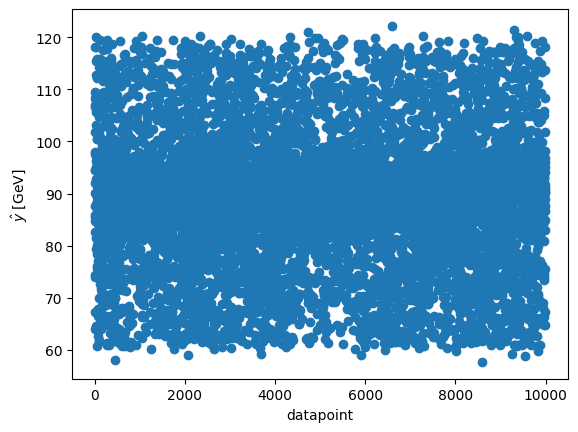

/var/folders/13/4h_rwpc12q15_80s7fq2msnw0000gp/T/ipykernel_55031/3891581152.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(range(len(y_hat)), [float(y_hat[i])/float(y[i]) for i in range(len(y_hat))])


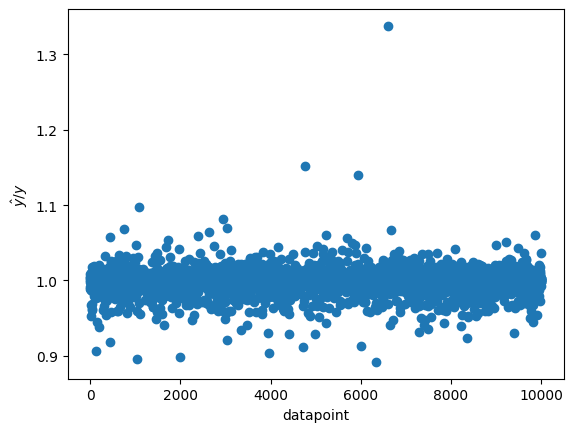

In [11]:
# Generate the training set
x, y = [], []
zee_data = pd.read_csv('./Zee.csv')
inv_mass = get_invariant_mass(zee_data.pt1, zee_data.pt2, zee_data.eta1, zee_data.eta2, zee_data.phi1, zee_data.phi2)
for index, row in zee_data.iterrows():
   x.append([row['pt1'] * row['pt2'] / (100*100), abs(row['eta1'] - row['eta2']), abs(row['phi1'] - row['phi2'])])

x = np.asarray(x)
y = np.asarray([[y] for y in inv_mass])/100.
x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Set up and initialize the NN
my_nn = torch.nn.Sequential(
    torch.nn.Linear(3, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
    torch.nn.Identity()
)

learning_rate = 0.01
epochs = 20
sgd = torch.optim.SGD(my_nn.parameters(), lr=learning_rate)  # use SGD optimizer
criterion = torch.nn.MSELoss()


# Train the NN
avg_losses = []
for epoch in range(epochs):
    avg_loss = 0
    for i in range(len(x)):
        sgd.zero_grad()
        y_hat = my_nn(x[i])
        loss = criterion(y_hat, y[i])
        loss.backward()
        avg_loss += loss.data
        sgd.step()

    avg_losses.append(avg_loss)
    print("Epoch {:3d}: MSE Loss {:5f}".format(epoch, avg_loss))

print("\nTraining complete!")



# Plot prediction of NN
y_hat = my_nn(x)
x, y_hat = x.detach().numpy(), y_hat.detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(len(y_hat)), [100 * float(y_hat[i]) for i in range(len(y_hat))])
ax.set_xlabel('datapoint')
ax.set_ylabel('$\hat{y}$ [GeV]')
# plt.savefig("./example_1.2e_prediction.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(len(y_hat)), [float(y_hat[i])/float(y[i]) for i in range(len(y_hat))])
ax.set_xlabel('datapoint')
ax.set_ylabel('$\hat{y}/y$')
# plt.savefig("./example_1.2e_rel_error.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()